### Load Library ###

In [1]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import json

### Set Up Dataset ###
Download nuScenes dataset and uncompress it.

In [3]:
# ! tar -xf drive/MyDrive/NuImages/nuimages-v1.0-mini.tgz -C /content/drive/MyDrive/NuImages/mini/
# ! tar -xf drive/MyDrive/NuImages/normal/nuimages-v1.0-all-samples.tgz -C /content/drive/MyDrive/NuImages/images/
# ! tar -xf drive/MyDrive/NuImages/nuimages-v1.0-all-metadata.tgz -C /content/drive/MyDrive/NuImages/images/
# ! pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

In [2]:
# Initialization
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from nuimages import NuImages

# Load NuImages
nuim_train = NuImages(dataroot='/root/data/nuimages/images/', version='v1.0-train', verbose=True, lazy=False)
nuim_val = NuImages(dataroot='/root/data/nuimages/images/', version='v1.0-val', verbose=True, lazy=False)
nuim_test = NuImages(dataroot='/root/data/nuimages/images/', version='v1.0-test', verbose=True, lazy=False)

Loading nuImages tables for version v1.0-train...
Loaded 12 attribute(s) in 0.000s,
Loaded 2022 calibrated_sensor(s) in 0.021s,
Loaded 25 category(s) in 0.000s,
Loaded 872181 ego_pose(s) in 11.772s,
Loaded 350 log(s) in 0.001s,
Loaded 557715 object_ann(s) in 6.591s,
Loaded 67279 sample(s) in 0.090s,
Loaded 872181 sample_data(s) in 4.247s,
Loaded 6 sensor(s) in 0.000s,
Loaded 73755 surface_ann(s) in 1.568s,
Done loading in 24.291 seconds (lazy=False).
Loading nuImages tables for version v1.0-val...
Loaded 12 attribute(s) in 0.000s,
Loaded 464 calibrated_sensor(s) in 0.006s,
Loaded 25 category(s) in 0.000s,
Loaded 213185 ego_pose(s) in 3.725s,
Loaded 82 log(s) in 0.000s,
Loaded 136074 object_ann(s) in 0.724s,
Loaded 16445 sample(s) in 0.031s,
Loaded 213185 sample_data(s) in 0.890s,
Loaded 6 sensor(s) in 0.000s,
Loaded 17995 surface_ann(s) in 0.336s,
Done loading in 5.715 seconds (lazy=False).
Loading nuImages tables for version v1.0-test...
Loaded 12 attribute(s) in 0.000s,
Loaded 346 ca

List all the categories and define a function to look up the category name according to category token.

In [3]:
NUM_CATEGORY = len(nuim_train.category)

# List all the categories
for cate in nuim_train.category:
    print(cate['name'])

# Dictionary to find category name according to the token
category_to_name = dict()
# Dictionary to find the category index according to category name
category_to_index = dict()
# Dictionary to find the category name according to category index
index_to_category = dict()

for i, cate in enumerate(nuim_train.category):
    category_to_name.update({cate['token'] : cate['name']})
    category_to_index.update({cate['name'] : i})
    index_to_category.update({i : cate['name']})

# Dictionary to find image's filename according to the token
token_to_filename = dict()

for sample in nuim_train.sample:
    # Get filename
    # filename = nuim_train.get('sample_data', sample['key_camera_token'])['filename'].split('/')[-1].split('.')[0]
    # Get full path
    filename = nuim_train.get('sample_data', sample['key_camera_token'])['filename'].split('.')[0]
    token_to_filename.update({sample['key_camera_token'] : filename})

for sample in nuim_val.sample:
    # Get filename
    # filename = nuim_train.get('sample_data', sample['key_camera_token'])['filename'].split('/')[-1].split('.')[0]
    # Get full path
    filename = nuim_val.get('sample_data', sample['key_camera_token'])['filename'].split('.')[0]
    token_to_filename.update({sample['key_camera_token'] : filename})
    

for sample in nuim_test.sample:
    # Get filename
    # filename = nuim_train.get('sample_data', sample['key_camera_token'])['filename'].split('/')[-1].split('.')[0]
    # Get full path
    filename = nuim_test.get('sample_data', sample['key_camera_token'])['filename'].split('.')[0]
    token_to_filename.update({sample['key_camera_token'] : filename})

animal
flat.driveable_surface
human.pedestrian.adult
human.pedestrian.child
human.pedestrian.construction_worker
human.pedestrian.personal_mobility
human.pedestrian.police_officer
human.pedestrian.stroller
human.pedestrian.wheelchair
movable_object.barrier
movable_object.debris
movable_object.pushable_pullable
movable_object.trafficcone
static_object.bicycle_rack
vehicle.bicycle
vehicle.bus.bendy
vehicle.bus.rigid
vehicle.car
vehicle.construction
vehicle.ego
vehicle.emergency.ambulance
vehicle.emergency.police
vehicle.motorcycle
vehicle.trailer
vehicle.truck


In [ ]:
# Save the dict
dic_path = '/root/data/nuimages/index_to_category.json'
with open(dic_path, 'w') as f:
    json.dump(index_to_category, f)

Transfer the NuImage dataset annotation to tranable format.

In [5]:
# Image size
WIDTH = 1600
HEIGHT = 900

# Data dictionary
train_set = dict()
val_set = dict()
test_set = dict()

# For train set
# Get all the objects
for ob in nuim_train.object_ann:
    # Get the token of the sample that contains the object
    sample_data_token = ob['sample_data_token']
    if ob['mask'] is None:
        continue
    # Get sample's filename
    filename = token_to_filename[sample_data_token]
    # Look up category name of the object
    category = category_to_name[ob['category_token']]
    # bbox format: [xmin, ymin, xmax, ymax]
    bbox = ob['bbox']
    # Transfer bbox to: [x_center_in_ratio, y_center_in_ratio, width_in_ratio, height_in_ratio]
    x_center = ((bbox[0] + bbox[2]) / 2) / WIDTH
    y_center = ((bbox[1] + bbox[3]) / 2) / HEIGHT
    width = (bbox[2] - bbox[0]) / WIDTH
    height = (bbox[3] - bbox[1]) / HEIGHT
    bbox = [x_center, y_center, width, height]

    # if x_center > 1 or y_center > 1 or width > 1 or height > 1:
    #     print(f'{filename}: {bbox}')

    # Get the category index according to category name
    index = category_to_index[category]
    
    # If the image is visited
    if sample_data_token in train_set:
        if category in train_set[sample_data_token]:
            train_set[sample_data_token][category].append(bbox)
        else:
            train_set[sample_data_token].update({category : [bbox]})
    # Image not visited
    else:
        train_set.update({sample_data_token : {category : [bbox]}})

# For validation set
for ob in nuim_val.object_ann:
    # Get the token of the sample that contains the object
    sample_data_token = ob['sample_data_token']
    if ob['mask'] is None:
        continue
    # Get sample's filename
    filename = token_to_filename[sample_data_token]
    # Look up category name of the object
    category = category_to_name[ob['category_token']]
    # bbox format: [xmin, ymin, xmax, ymax]
    bbox = ob['bbox']
    # Transfer bbox to: [x_center_in_ratio, y_center_in_ratio, width_in_ratio, height_in_ratio]
    x_center = ((bbox[0] + bbox[2]) / 2) / WIDTH
    y_center = ((bbox[1] + bbox[3]) / 2) / HEIGHT
    width = (bbox[2] - bbox[0]) / WIDTH
    height = (bbox[3] - bbox[1]) / HEIGHT
    bbox = [x_center, y_center, width, height]

    # if x_center > 1 or y_center > 1 or width > 1 or height > 1 or filename == 'samples/CAM_BACK_LEFT/n003-2018-01-04-17-14-29+0800__CAM_BACK_LEFT__1515057845331004':
    #     print(f'{filename}: {bbox}')
    #     print(ob)

    # Get the category index according to category name
    index = category_to_index[category]
    
    # If the image is visited
    if sample_data_token in val_set:
        if category in val_set[sample_data_token]:
            val_set[sample_data_token][category].append(bbox)
        else:
            val_set[sample_data_token].update({category : [bbox]})
    # Image not visited
    else:
        val_set.update({sample_data_token : {category : [bbox]}})

# For test set
for ob in nuim_test.object_ann:
    # Get the token of the sample that contains the object
    sample_data_token = ob['sample_data_token']
    if ob['mask'] is None:
        continue
    # Get sample's filename
    filename = token_to_filename[sample_data_token]
    # Look up category name of the object
    category = category_to_name[ob['category_token']]
    # bbox format: [xmin, ymin, xmax, ymax]
    bbox = ob['bbox']
    # Transfer bbox to: [x_center_in_ratio, y_center_in_ratio, width_in_ratio, height_in_ratio]
    x_center = ((bbox[0] + bbox[2]) / 2) / WIDTH
    y_center = ((bbox[1] + bbox[3]) / 2) / HEIGHT
    width = (bbox[2] - bbox[0]) / WIDTH
    height = (bbox[3] - bbox[1]) / HEIGHT
    bbox = [x_center, y_center, width, height]

    # Get the category index according to category name
    index = category_to_index[category]
    
    # If the image is visited
    if sample_data_token in test_set:
        if category in test_set[sample_data_token]:
            test_set[sample_data_token][category].append(bbox)
        else:
            test_set[sample_data_token].update({category : [bbox]})
    # Image not visited
    else:
        test_set.update({sample_data_token : {category : [bbox]}})





Find bad bbox.

In [5]:
for token in token_to_filename.keys():
    if token_to_filename[token] == 'samples/CAM_BACK_LEFT/n003-2018-01-04-17-14-29+0800__CAM_BACK_LEFT__1515057845331004':
        print(token)

4bdcc17d9bbb412987b4ff9a6f7f1bfa


{'token': '4bdcc17d9bbb412987b4ff9a6f7f1bfa', 'sample_token': '1915f79e8824444c8d950ca8b5e75186', 'ego_pose_token': '266df28b08074e309f25eaf67e8336be', 'calibrated_sensor_token': '8a031387a5e05efa9836c621e16f5232', 'filename': 'samples/CAM_BACK_LEFT/n003-2018-01-04-17-14-29+0800__CAM_BACK_LEFT__1515057845331004.jpg', 'fileformat': 'jpg', 'width': 1600, 'height': 900, 'timestamp': 1515057845331004, 'is_key_frame': True, 'prev': 'eecb595af9c7417993488c2df58af3fb', 'next': '653c2af558cf403e86cf44adf701ce0a'}
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
489
1111


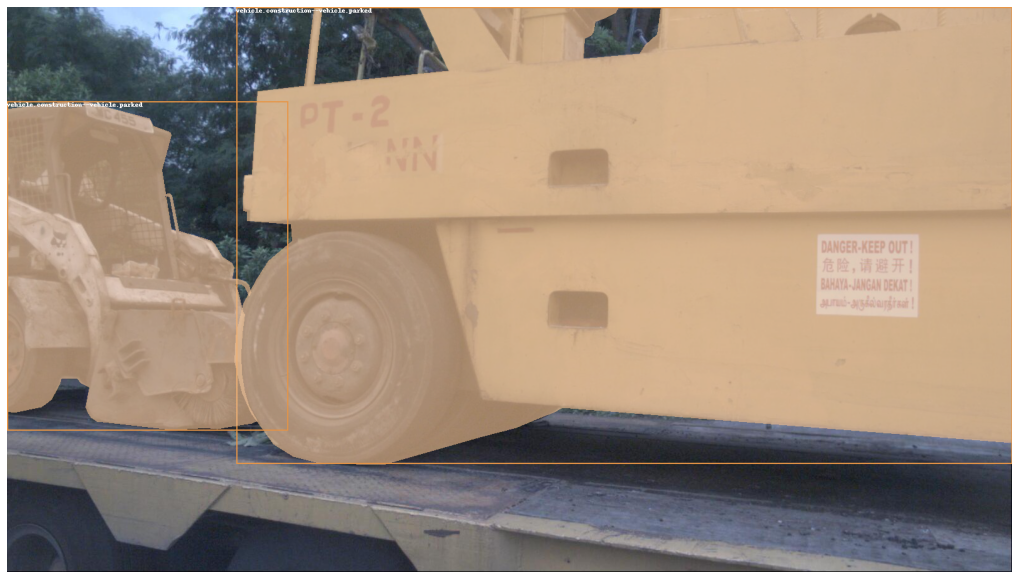

In [23]:
bad_token = '4bdcc17d9bbb412987b4ff9a6f7f1bfa'

nuim_val.render_image(bad_token, annotation_type='all', with_category=True, with_attributes=True, box_line_width=-1, render_scale=2)
bad_sample = nuim_val.get('sample_data', bad_token)
print(bad_sample)

bad_sample.items()

semantic_mask, instance_mask = nuim_val.get_segmentation(bad_token)
print(instance_mask)
print(instance_mask.tolist()[0].index(1))
print(1600 - instance_mask.tolist()[0].index(1))

Create the train annotation folder, write the annotitions to .txt files, with the format `category_index x_center_in_ratio y_center_in_ratio width_in_ratio height_in_ratio`.:

In [6]:
! rm -rf /root/data/nuimages/labels
! cd /root/data/nuimages && mkdir labels labels/samples
! cd /root/data/nuimages/labels/samples && mkdir CAM_BACK CAM_BACK_LEFT CAM_BACK_RIGHT CAM_FRONT CAM_FRONT_LEFT CAM_FRONT_RIGHT

folder = '/root/data/nuimages/labels/'
for sample in nuim_train.sample:
    token = sample['key_camera_token']
    filename = token_to_filename[token]
    if token in train_set:
        with open(folder + filename + '.txt', 'w') as f:
            for cate in train_set[token].keys():
                index = category_to_index[cate]
                for obj in train_set[token][cate]:
                    f.write(f'{index} {obj[0]:.6f} {obj[1]:.6f} {obj[2]:.6f} {obj[3]:.6f}\n')
    # There are some samples without annotations
    else:
        open(folder + filename + '.txt', 'w')

folder = '/root/data/nuimages/labels/'
for sample in nuim_val.sample:
    token = sample['key_camera_token']
    
    filename = token_to_filename[token]
    if token in val_set:
        with open(folder + filename + '.txt', 'w') as f:
            for cate in val_set[token].keys():
                index = category_to_index[cate]
                for obj in val_set[token][cate]:
                    f.write(f'{index} {obj[0]:.6f} {obj[1]:.6f} {obj[2]:.6f} {obj[3]:.6f}\n')
    # There are some samples without annotations
    else:
        open(folder + filename + '.txt', 'w')

In [ ]:
folder = '/root/data/nuimages/labels/'
for sample in nuim_test.sample:
    token = sample['key_camera_token']
    filename = token_to_filename[token]
    if token in train_set:
        with open(folder + filename + '.txt', 'w') as f:
            for cate in train_set[token].keys():
                index = category_to_index[cate]
                for obj in train_set[token][cate]:
                    f.write(f'{index} {obj[0]:.6f} {obj[1]:.6f} {obj[2]:.6f} {obj[3]:.6f}\n')
    # There are some samples without annotations
    else:
        open(folder + filename + '.txt', 'w')


Create a .txt file discripting where the files are stored.

In [4]:
! cd /root/data/nuimages && rm -rf train.txt val.txt
folder = '/root/data/nuimages/images/'

path = '/root/data/nuimages/train.txt'
with open(path, 'w') as f:
    for sample in nuim_train.sample:
        filename = folder + nuim_train.get('sample_data', sample['key_camera_token'])['filename']
        f.write(filename + '\n')

path = '/root/data/nuimages/val.txt'
with open(path, 'w') as f:
    for sample in nuim_val.sample:
        filename = folder + nuim_val.get('sample_data', sample['key_camera_token'])['filename'] 
        f.write(filename + '\n')


In [ ]:
! cd /root/data/nuimages && rm -rf test.txt
folder = '/root/data/nuimages/images/'

path = '/root/data/nuimages/test.txt'
with open(path, 'w') as f:
    for sample in nuim_test.sample:
        filename = folder + nuim_test.get('sample_data', sample['key_camera_token'])['filename']  
        f.write(filename + '\n')

Use a subset of the dataset.

In [7]:
! cd /root/data/nuimages && rm -rf train_sub.txt val_sub.txt
folder = '/root/data/nuimages/images/'
num_train = 20000

path = '/root/data/nuimages/train_sub.txt'
with open(path, 'w') as f:
    for sample in nuim_train.sample:
        filename = folder + nuim_train.get('sample_data', sample['key_camera_token'])['filename']  
        f.write(filename + '\n')
        num_train -= 1
        if num_train <= 0:
            break

num_val = 2000
path = '/root/data/nuimages/val_sub.txt'
with open(path, 'w') as f:
    for sample in nuim_val.sample:
        filename = folder + nuim_val.get('sample_data', sample['key_camera_token'])['filename'] 
        f.write(filename + '\n')
        num_val -= 1
        if num_val <= 0:
            break

Create the name list of the categories.

In [24]:
names = [index_to_category[idx] for idx in range(NUM_CATEGORY)]
print(names)
# print(index_to_category)

['animal', 'flat.driveable_surface', 'human.pedestrian.adult', 'human.pedestrian.child', 'human.pedestrian.construction_worker', 'human.pedestrian.personal_mobility', 'human.pedestrian.police_officer', 'human.pedestrian.stroller', 'human.pedestrian.wheelchair', 'movable_object.barrier', 'movable_object.debris', 'movable_object.pushable_pullable', 'movable_object.trafficcone', 'static_object.bicycle_rack', 'vehicle.bicycle', 'vehicle.bus.bendy', 'vehicle.bus.rigid', 'vehicle.car', 'vehicle.construction', 'vehicle.ego', 'vehicle.emergency.ambulance', 'vehicle.emergency.police', 'vehicle.motorcycle', 'vehicle.trailer', 'vehicle.truck']


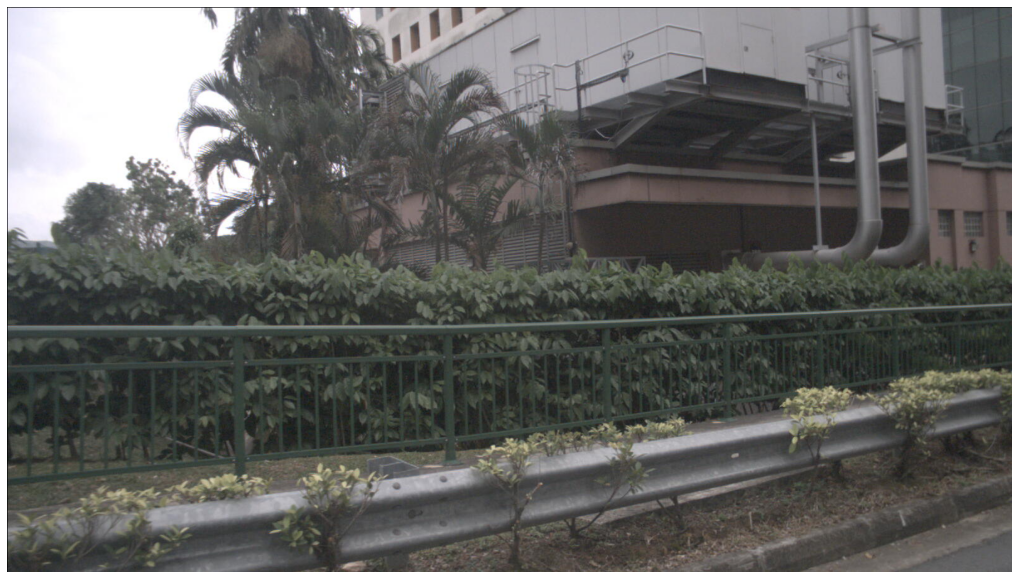

In [6]:
# Image without annotations
key_camera_token = 'b81a89f95b144f6cbf86ff7b21887442'
nuim_train.render_image(key_camera_token, annotation_type='objects', with_category=True, with_attributes=True, box_line_width=-1, render_scale=2)

Sample is the set of annotated key frames, Sample_data is set of all the images, the key_camera_token in sample is the token of the images in sample_data. 



In [ ]:
sample_idx = 80
sample = nuim_train.sample[sample_idx]
key_camera_token = sample['key_camera_token']
print(sample)

{'token': '00519c60af994bfdbeb1a2c358539240', 'timestamp': 1535341184520176, 'log_token': '54df0acc67964bf88c47d7ecc32a9169', 'key_camera_token': 'f2665eb2f79c4594a9f95d606abe4b11'}


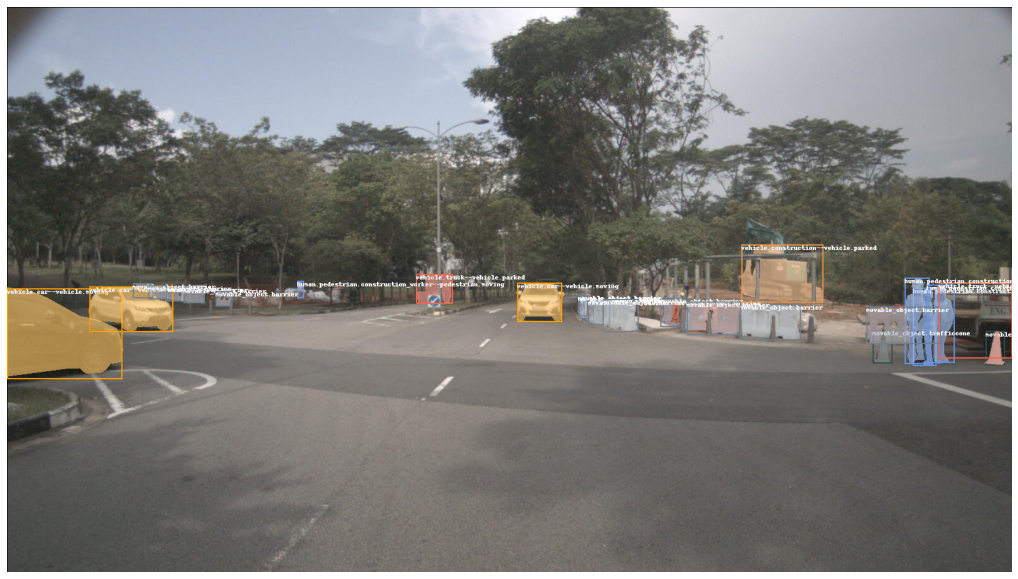

In [7]:
# Image with annotation
key_camera_token = '885437043b694431aa939ec73cd24f30'
nuim_train.render_image(key_camera_token, annotation_type='objects', with_category=True, with_attributes=True, box_line_width=-1, render_scale=2)

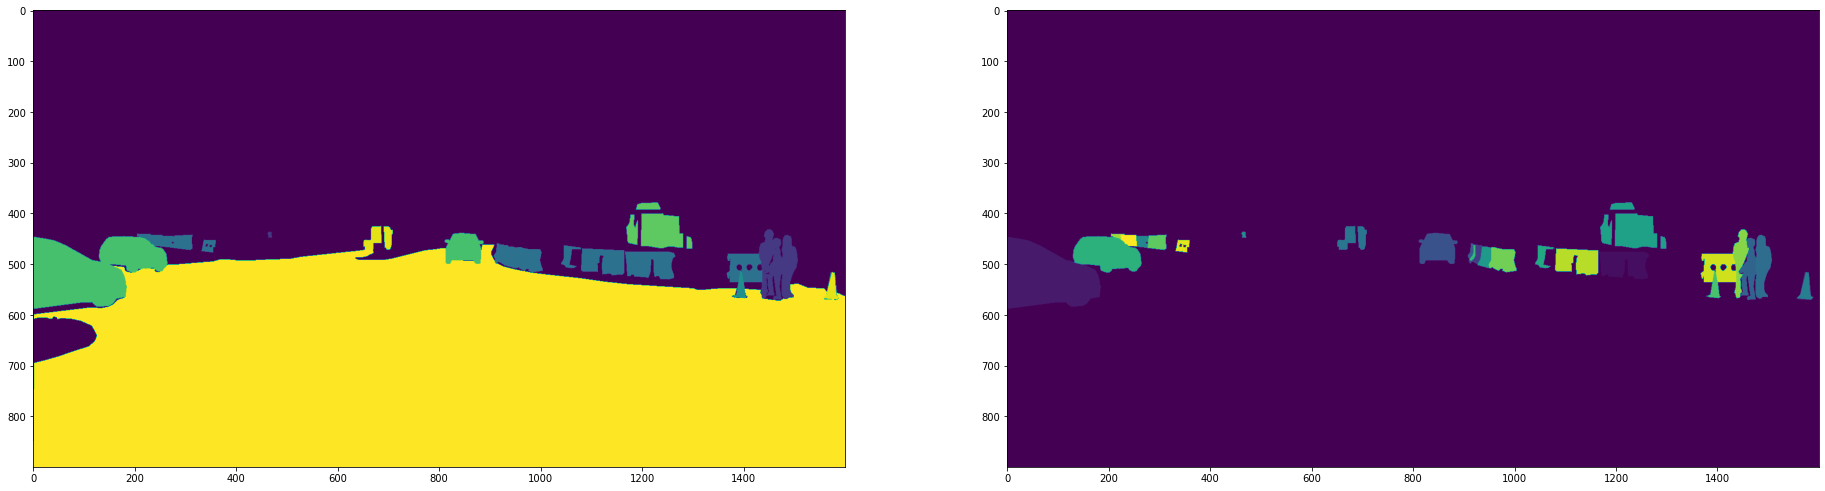

(900, 1600)


In [8]:
semantic_mask, instance_mask = nuim_train.get_segmentation(key_camera_token)
plt.figure(figsize=(32, 9))

plt.subplot(1, 2, 1)
plt.imshow(semantic_mask)
plt.subplot(1, 2, 2)
plt.imshow(instance_mask)

plt.show()
print(semantic_mask.shape)

### Set up YOLOv4 Model

In [2]:
from models import models

device = 'cuda:2'

yolov4_tiny = models.Darknet('./cfg/yolov4-tiny-25.cfg').to(device)
# yolov4_tiny = torch.load('/content/drive/MyDrive/feature_mining/yolov4.pt', map_location=torch.device('cuda'))

Layer 0: {'type': 'convolutional', 'batch_normalize': 1, 'filters': 32, 'size': 3, 'stride': 2, 'pad': 1, 'activation': 'leaky'}
Layer 1: {'type': 'convolutional', 'batch_normalize': 1, 'filters': 64, 'size': 3, 'stride': 2, 'pad': 1, 'activation': 'leaky'}
Layer 2: {'type': 'convolutional', 'batch_normalize': 1, 'filters': 64, 'size': 3, 'stride': 1, 'pad': 1, 'activation': 'leaky'}
Layer 3: {'type': 'route_lhalf', 'layers': [-1]}
Layer 4: {'type': 'convolutional', 'batch_normalize': 1, 'filters': 32, 'size': 3, 'stride': 1, 'pad': 1, 'activation': 'leaky'}
Layer 5: {'type': 'convolutional', 'batch_normalize': 1, 'filters': 32, 'size': 3, 'stride': 1, 'pad': 1, 'activation': 'leaky'}
Layer 6: {'type': 'route', 'layers': [-1, -2]}
Layer 7: {'type': 'convolutional', 'batch_normalize': 1, 'filters': 64, 'size': 1, 'stride': 1, 'pad': 1, 'activation': 'leaky'}
Layer 8: {'type': 'route', 'layers': [-6, -1]}
Layer 9: {'type': 'maxpool', 'size': 2, 'stride': 2}
Layer 10: {'type': 'convolutio

In [ ]:
models.load_darknet_weights(yolov4_tiny, './runs/train/yolov4-tiny-all/weights/best_overall.pt')

In [ ]:
# Download COCO dataset
# ! bash /content/drive/MyDrive/COCO/get_coco.sh

In [ ]:
# Prepare weight
# ! cp /content/drive/MyDrive/feature_mining/yolov4.pt /content/PyTorch_YOLOv4/weights

In [ ]:
# Train
! python3 train.py --device 0,1 --batch-size 48 --img-size [640,640] --data './data/nuimages.yaml' --cfg './cfg/yolov4-tiny-25.cfg' --weights './runs/train/yolov4-tiny-v23/weights/last.pt' --name 'yolov4-tiny-new'


In [ ]:
# Test
! python3 test.py --device 0,1 --batch-size 48 --img-size 640 --data './data/nuimages.yaml' --cfg './cfg/yolov4-tiny-25.cfg' --weights './runs/train/yolov4-tiny-v23/weights/last.pt' --name 'yolov4-tiny-new'

Namespace(augment=False, batch_size=8, cfg='cfg/yolov4-tiny.cfg', conf_thres=0.001, data='./data/coco.yaml', device='0', exist_ok=False, img_size=640, iou_thres=0.65, name='exp', names='data/coco.names', project='runs/test', save_conf=False, save_json=True, save_txt=False, single_cls=False, task='val', verbose=False, weights=['weights/yolov4.pt'])
Using torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109MB)

Model Summary: 99 layers, 6056606 parameters, 6056606 gradients
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Scanning labels ../coco/labels/val2017.cache3 (4952 found, 0 missing, 48 empty, 0 duplicate, for 5000 images): 5000it [00:00, 15625.91it/s]
               Class      Images     Targets           P           R      mAP@.5 

Show model architechture.

In [7]:
for module in enumerate(yolov4_tiny.module_list):
   print(module)

(0, Sequential(
  (Conv2d): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm2d): BatchNorm2d(32, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.1, inplace=True)
))
(1, Sequential(
  (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm2d): BatchNorm2d(64, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.1, inplace=True)
))
(2, Sequential(
  (Conv2d): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (BatchNorm2d): BatchNorm2d(64, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.1, inplace=True)
))
(3, FeatureConcat_l())
(4, Sequential(
  (Conv2d): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (BatchNorm2d): BatchNorm2d(32, eps=0.0001, momentum=0.03, affine=T